In [1]:
import os
import glob
import re
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.features import geometry_mask
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import joblib

In [2]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\clipped_unlabeled"  

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

In [3]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


In [4]:
# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")

def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        
        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
    
    return np.array(features), np.array(labels)

features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)


Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230714_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230714_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230720_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230720_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230731_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230731_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230923_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230923_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\moff_20230717_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\moff_20230717_train.shp
Image: C:\Users\Student\D

In [5]:
# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [6]:
# Save the model
model_filename = "walrus_model_allislands2.joblib"
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")


Model saved to walrus_model_allislands2.joblib


In [7]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

  freshwater       0.91      0.88      0.90      8044
         ice       0.98      0.99      0.98     60098
       ocean       1.00      1.00      1.00    155893
        rock       0.98      0.97      0.97     18474
walrus_mixed       1.00      0.28      0.44       178
 walrus_pure       0.86      0.92      0.89        13

    accuracy                           0.99    242700
   macro avg       0.95      0.84      0.86    242700
weighted avg       0.99      0.99      0.99    242700


Predicting for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230714_image.tif...
Predicting classes for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230714_image.tif...
Image shape: (8, 445, 582)
Predictions shape: (258990,)
Predicting for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230720_image.tif...
Predicting classes for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230720_image.tif...
Image shape: (8, 556, 728)
Predictions shape: (404768,)
Predicting for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230731_image.tif...
Predicting classes for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230731_image.tif...
Image shape: (8, 488, 639)
Predictions shape: (311832,)
Predicting for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230923_image.tif...
Predicting classes for C:\Users\Student\Documents\101_walrus_data\

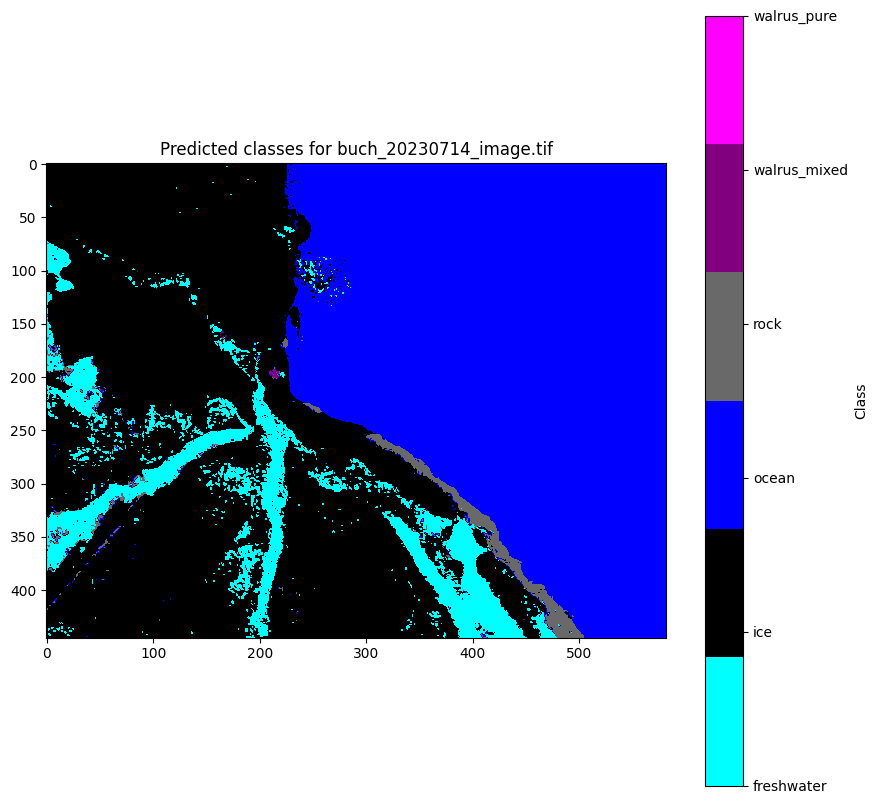

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230720_image.tif...
Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


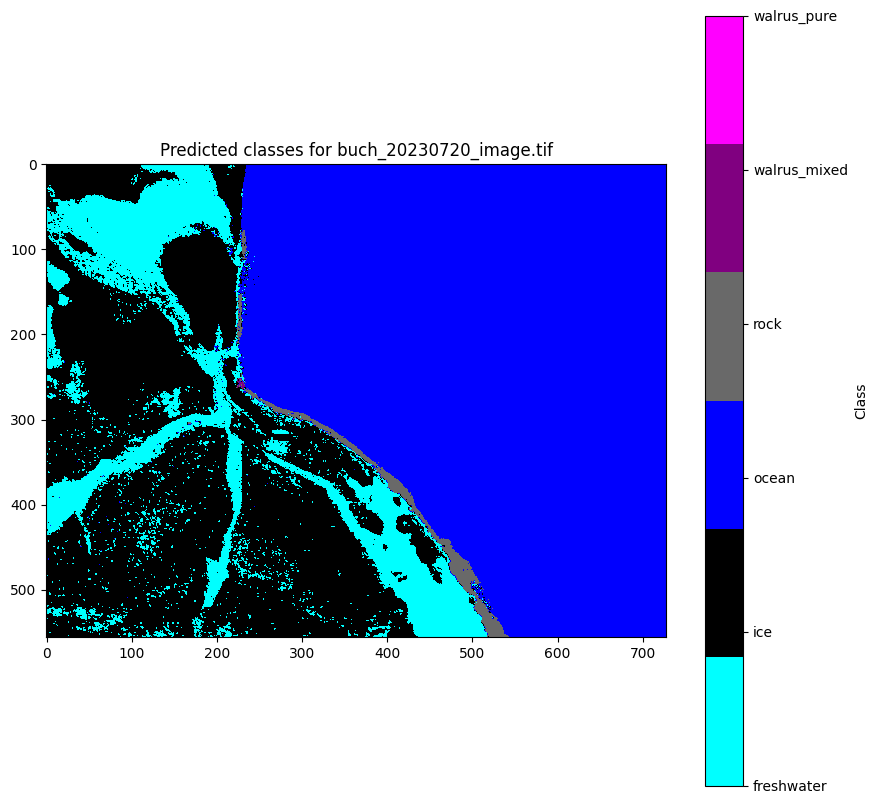

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230731_image.tif...
Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


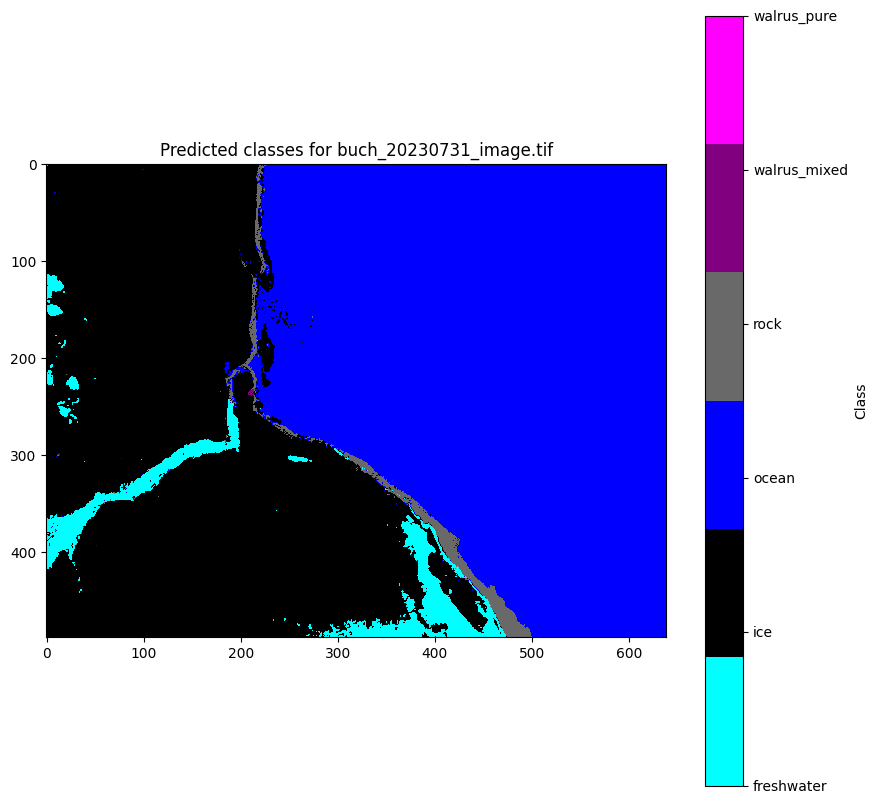

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230923_image.tif...
Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean']


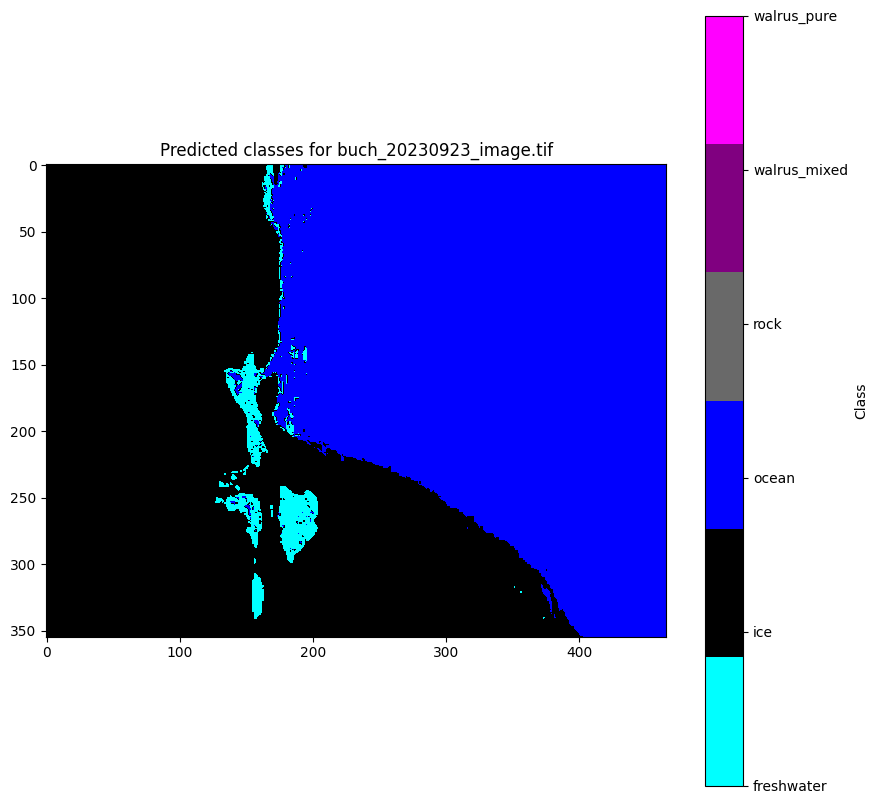

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\moff_20230717_image.tif...
Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


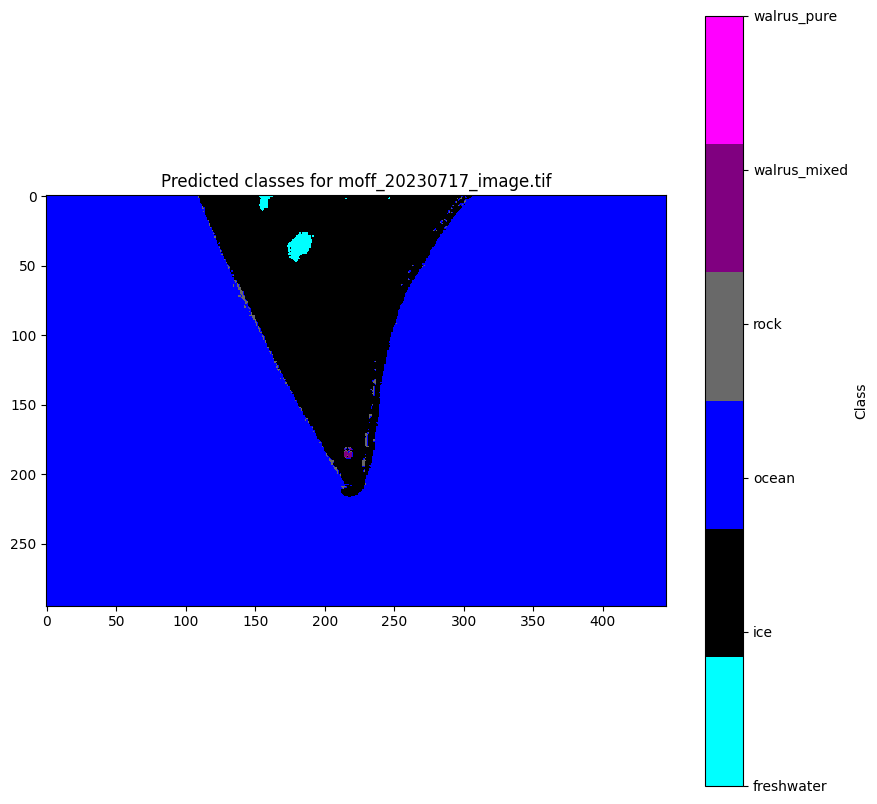

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pal_20230714_image.tif...
Labels present in pal_20230714_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed']


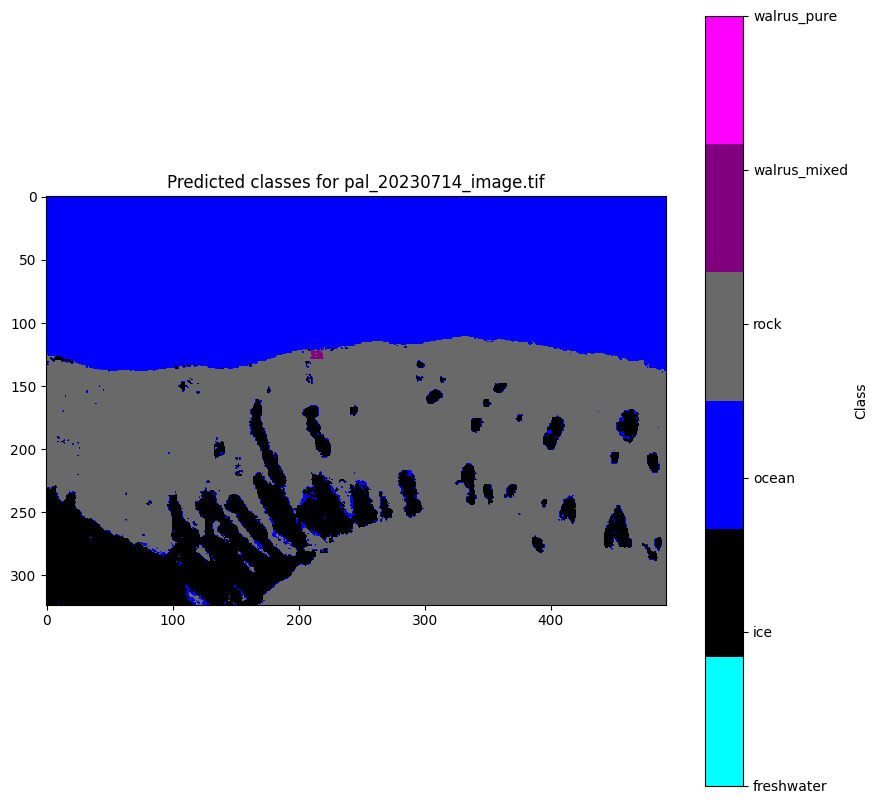

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pal_20230720_image.tif...
Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


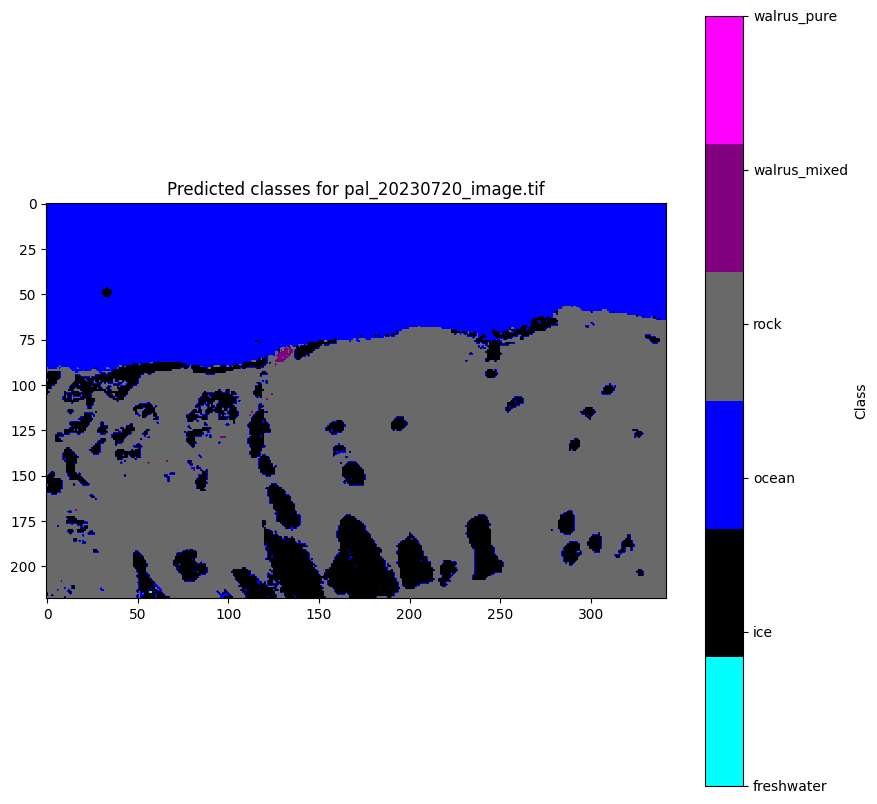

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pal_20230726_image.tif...
Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


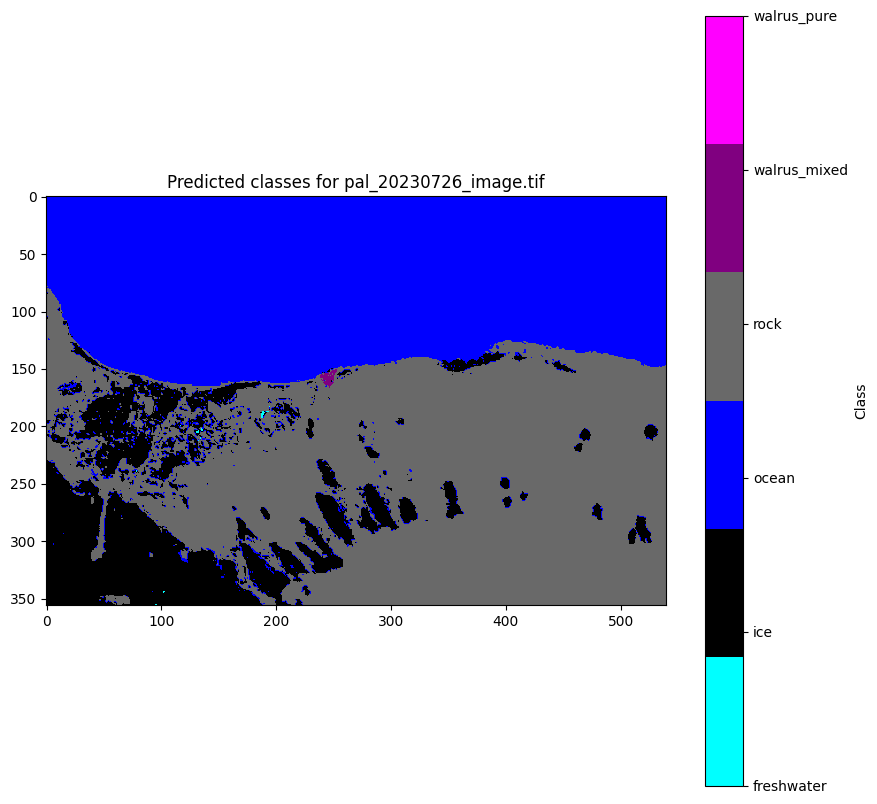

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\sars_20230714_image.tif...
Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


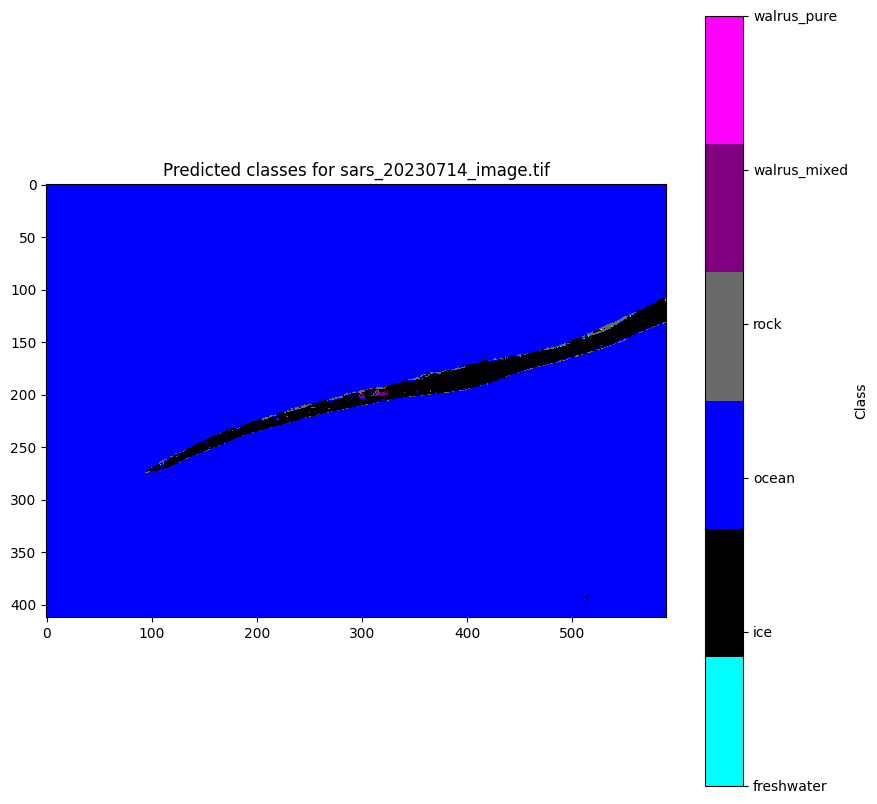

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\sars_20230803_image.tif...
Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


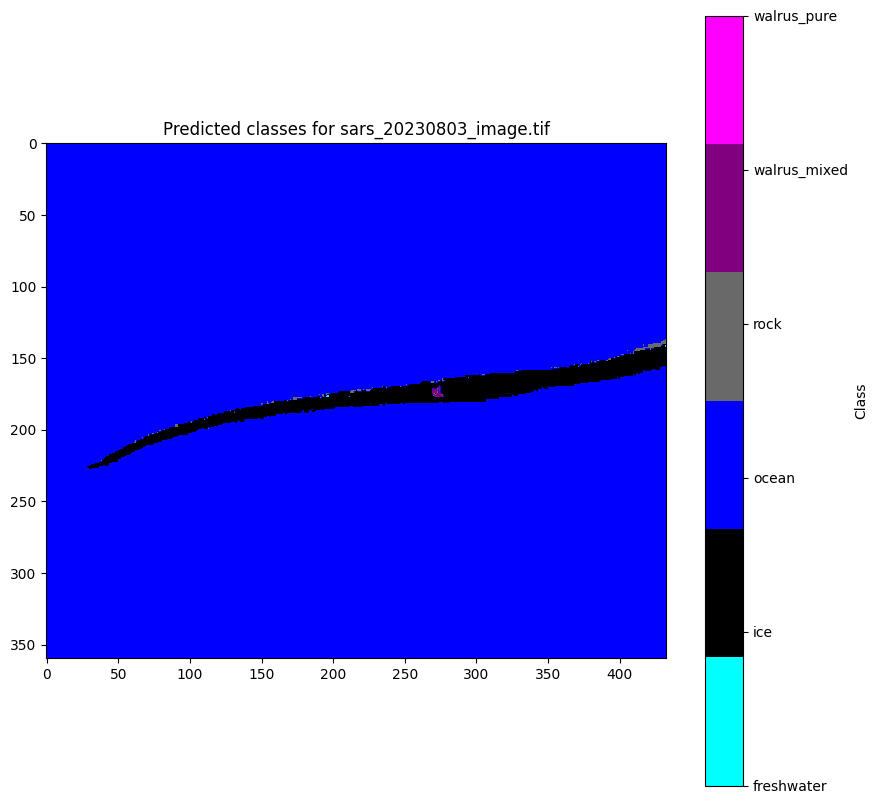

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230801_image.tif...
Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


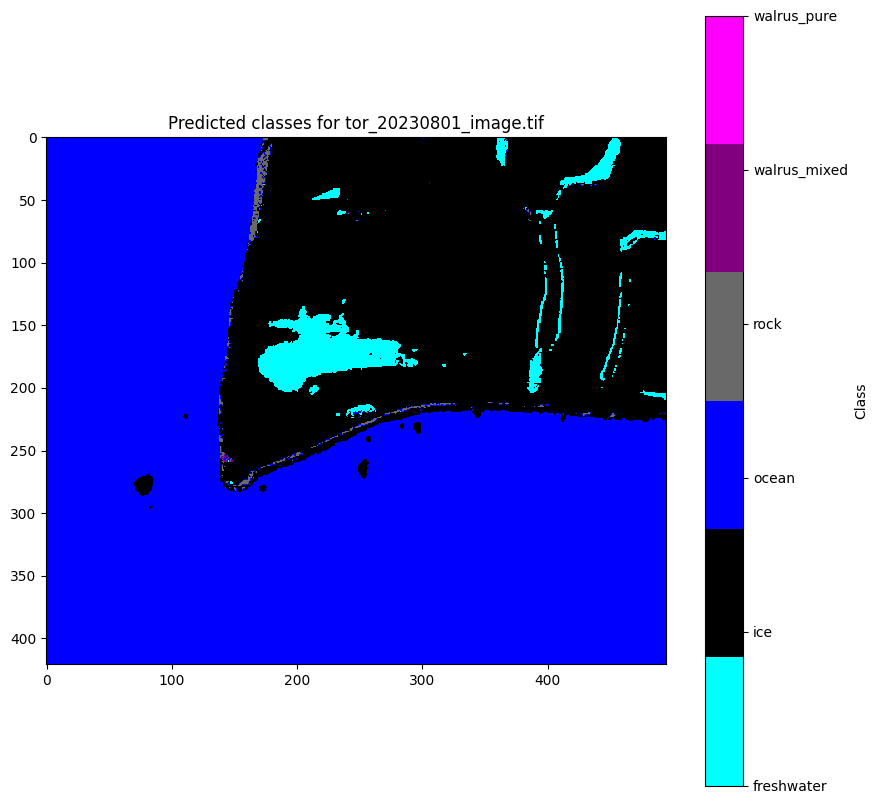

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230824_image.tif...
Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


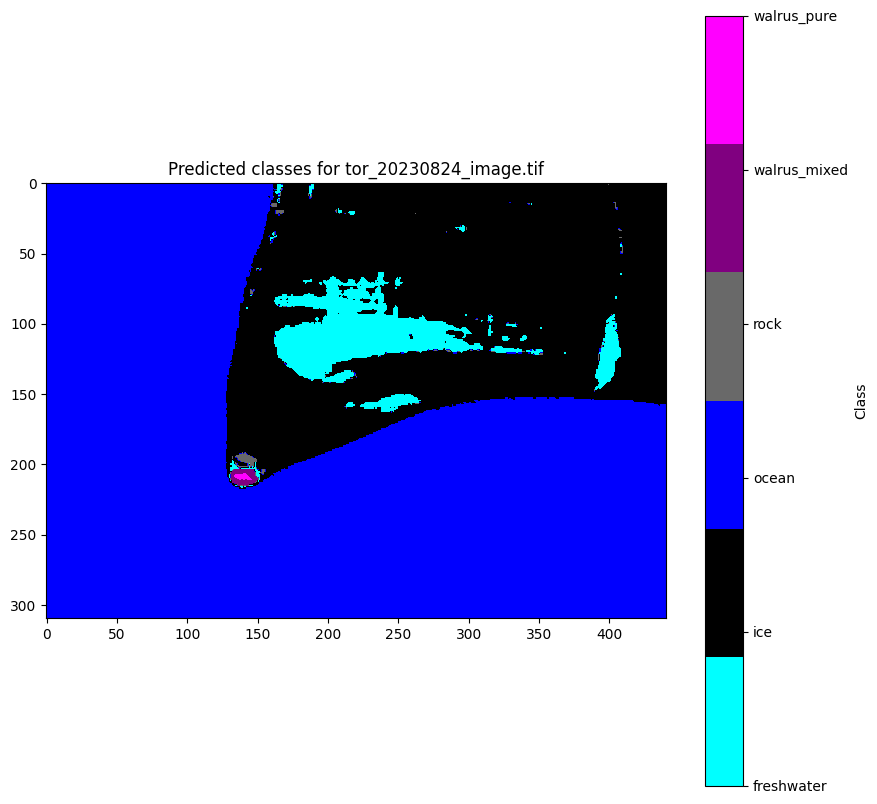

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230901_image.tif...
Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


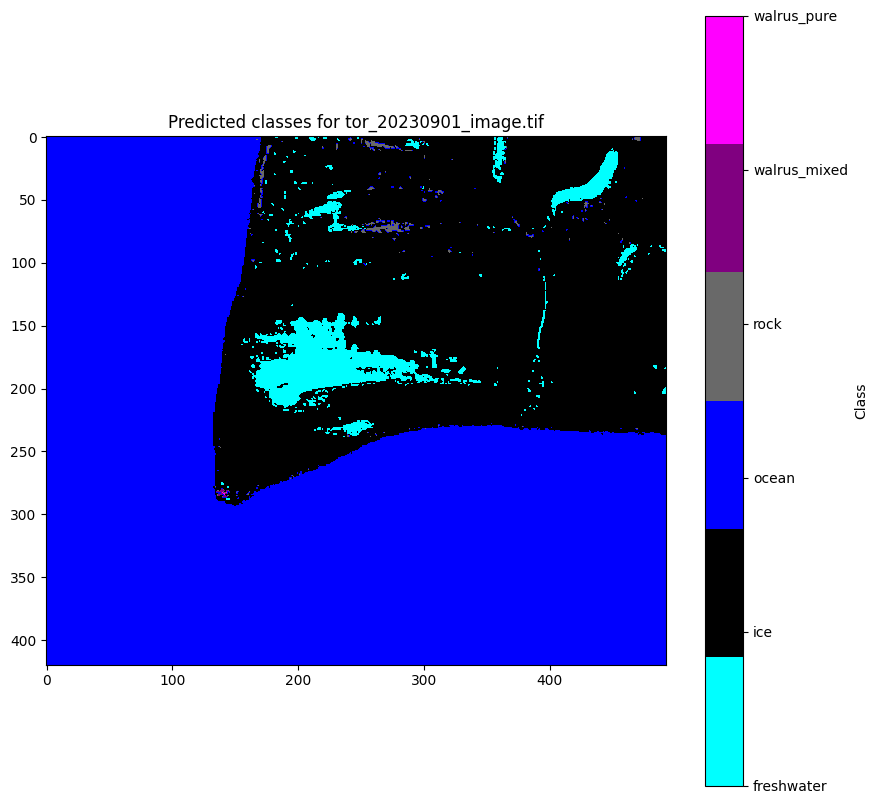

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230902_image.tif...
Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


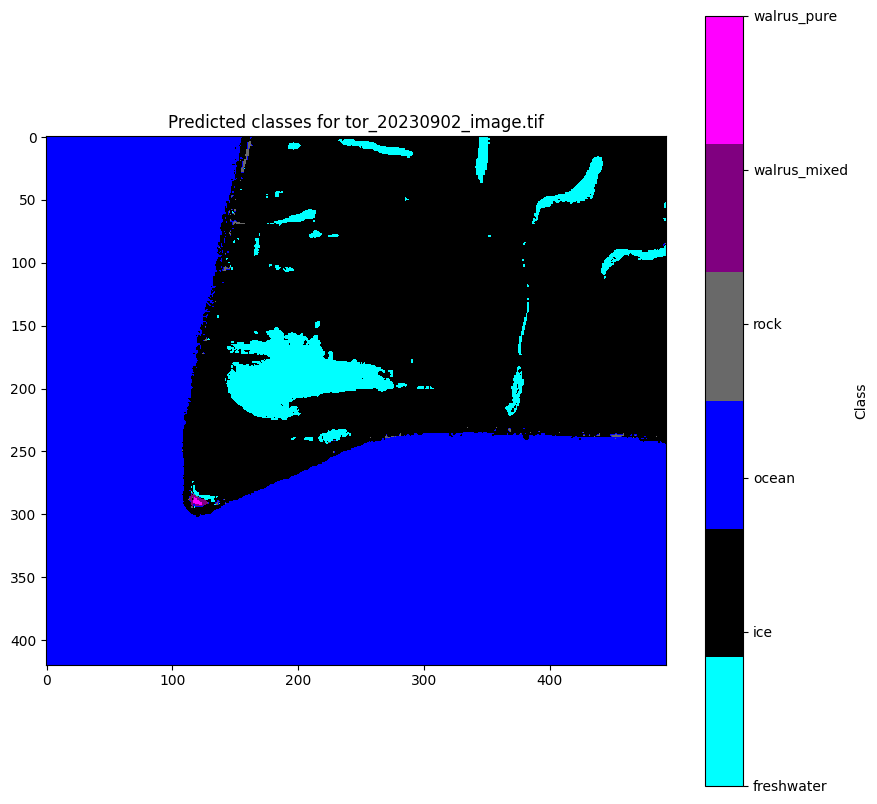

In [8]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    print(f"Predicting classes for {image_path}...")
    with rasterio.open(image_path) as src:
        image = src.read()
        print(f"Image shape: {image.shape}")
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        print(f"Predictions shape: {predictions.shape}")
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    print(f"Predicting for {image_path}...")
    predicted_images[image_path] = predict_image(image_path, model)

# Define a color map for the labels
label_colors = {'ice': 'black', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'purple', 'freshwater': 'cyan', 'ocean': 'blue'}
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    print(f"Plotting predicted image for {image_path}...")
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()



In [9]:
# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

for image_path in unlabeled_image_paths:
    print(f"Predicting for unlabeled image {image_path}...")
    predicted_image = predict_image(image_path, loaded_model)
    
    print(f"Plotting predicted image for {image_path}...")
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    plt.show()


Model loaded from walrus_model_allislands2.joblib


In [10]:
import os
import glob
import re
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.features import geometry_mask
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import joblib

In [11]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\clipped_unlabeled"  

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

In [12]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None


In [13]:
# Create a dictionary to store paired image and shapefile paths
file_pairs = {}
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


In [14]:
# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")

def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        
        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
    
    return np.array(features), np.array(labels)

features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)


Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230714_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230714_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230720_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230720_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230731_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230731_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230923_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\buch_20230923_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\moff_20230717_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\moff_20230717_train.shp
Image: C:\Users\Student\D

In [15]:
# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the model
model_filename = "walrus_model_allislands3.joblib"
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")

Model saved to walrus_model_allislands3.joblib


In [16]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

  freshwater       0.91      0.88      0.90      8044
         ice       0.98      0.99      0.98     60098
       ocean       1.00      1.00      1.00    155893
        rock       0.98      0.97      0.97     18474
walrus_mixed       1.00      0.28      0.44       178
 walrus_pure       0.86      0.92      0.89        13

    accuracy                           0.99    242700
   macro avg       0.95      0.84      0.86    242700
weighted avg       0.99      0.99      0.99    242700


In [17]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    print(f"Predicting classes for {image_path}...")
    with rasterio.open(image_path) as src:
        image = src.read()
        print(f"Image shape: {image.shape}")
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        print(f"Predictions shape: {predictions.shape}")
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    print(f"Predicting for {image_path}...")
    predicted_images[image_path] = predict_image(image_path, model)

Predicting for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230714_image.tif...
Predicting classes for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230714_image.tif...
Image shape: (8, 445, 582)
Predictions shape: (258990,)
Predicting for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230720_image.tif...
Predicting classes for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230720_image.tif...
Image shape: (8, 556, 728)
Predictions shape: (404768,)
Predicting for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230731_image.tif...
Predicting classes for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230731_image.tif...
Image shape: (8, 488, 639)
Predictions shape: (311832,)
Predicting for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230923_image.tif...
Predicting classes for C:\Users\Student\Documents\101_walrus_data\

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230714_image.tif...
Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


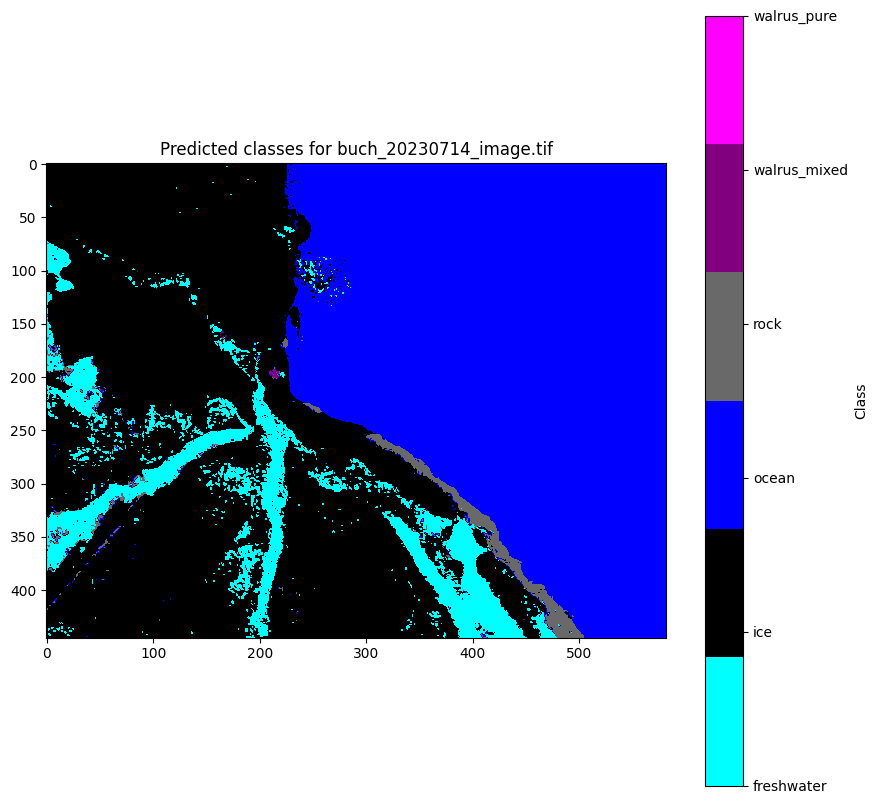

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230720_image.tif...
Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


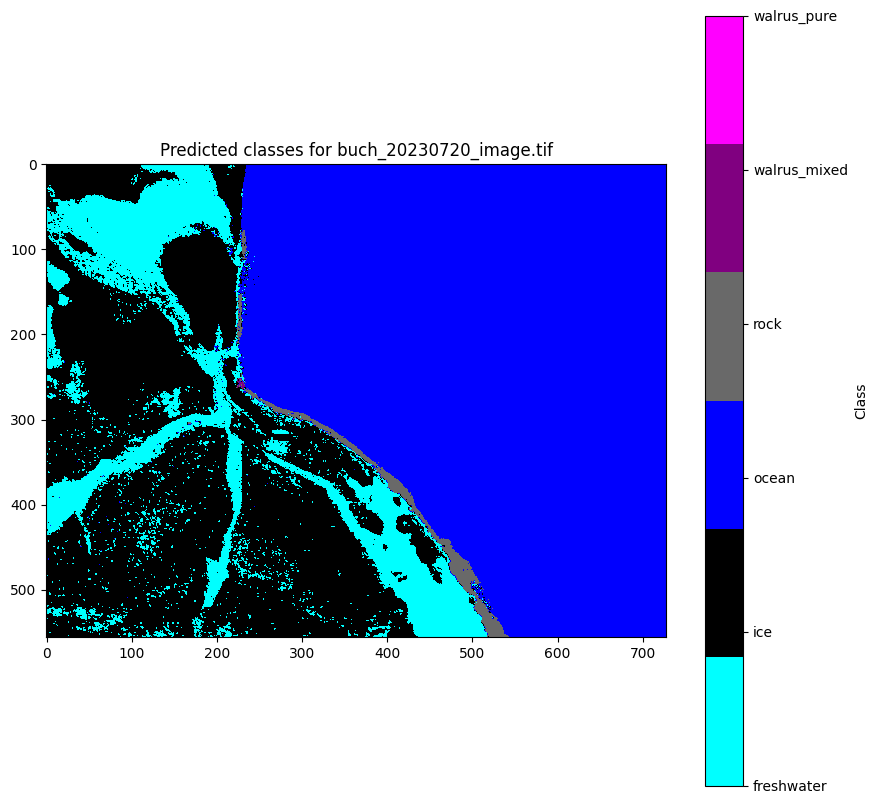

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230731_image.tif...
Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


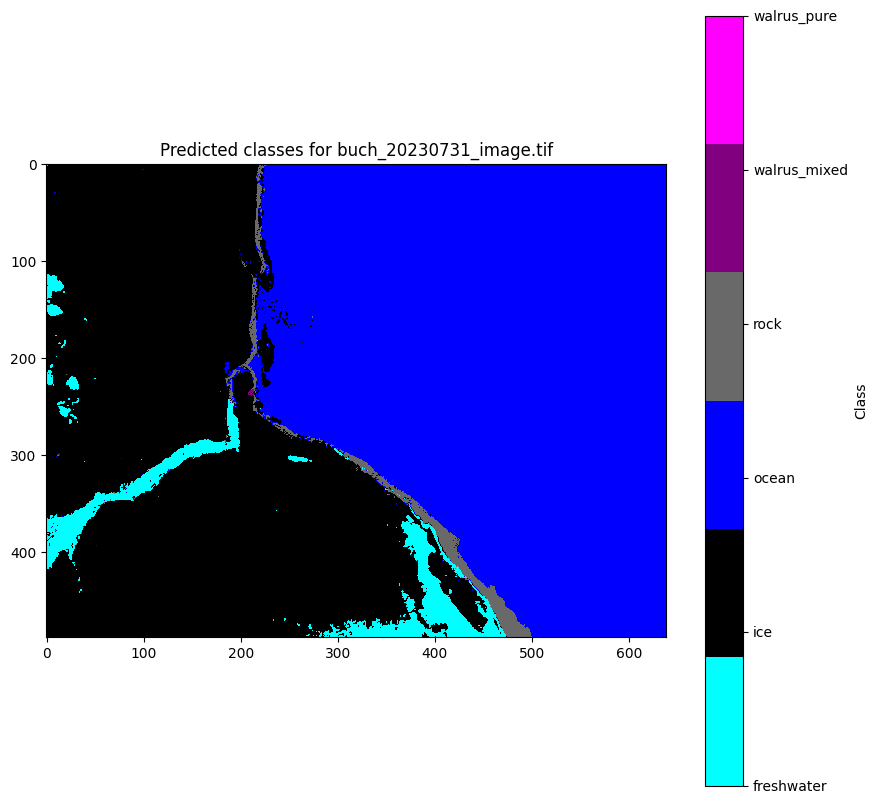

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230923_image.tif...
Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean']


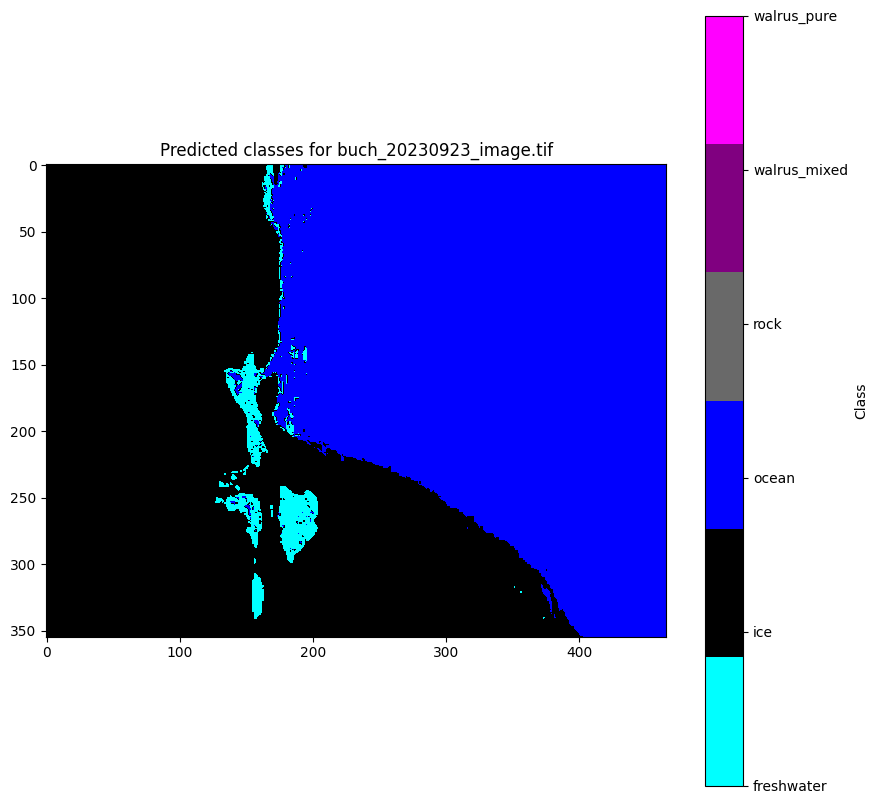

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\moff_20230717_image.tif...
Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


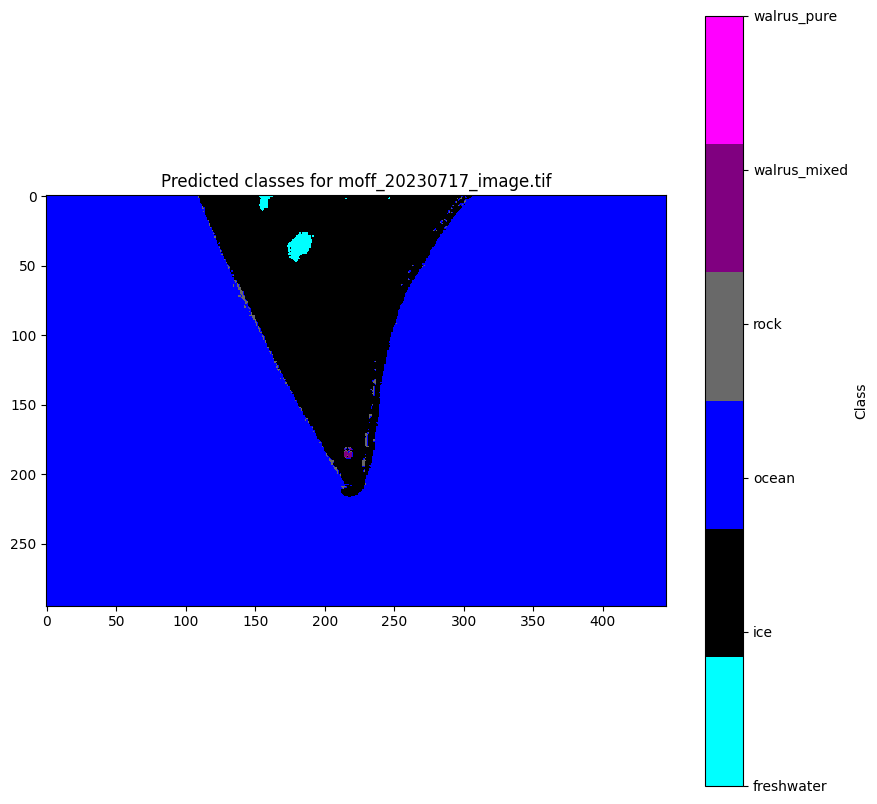

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pal_20230714_image.tif...
Labels present in pal_20230714_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed']


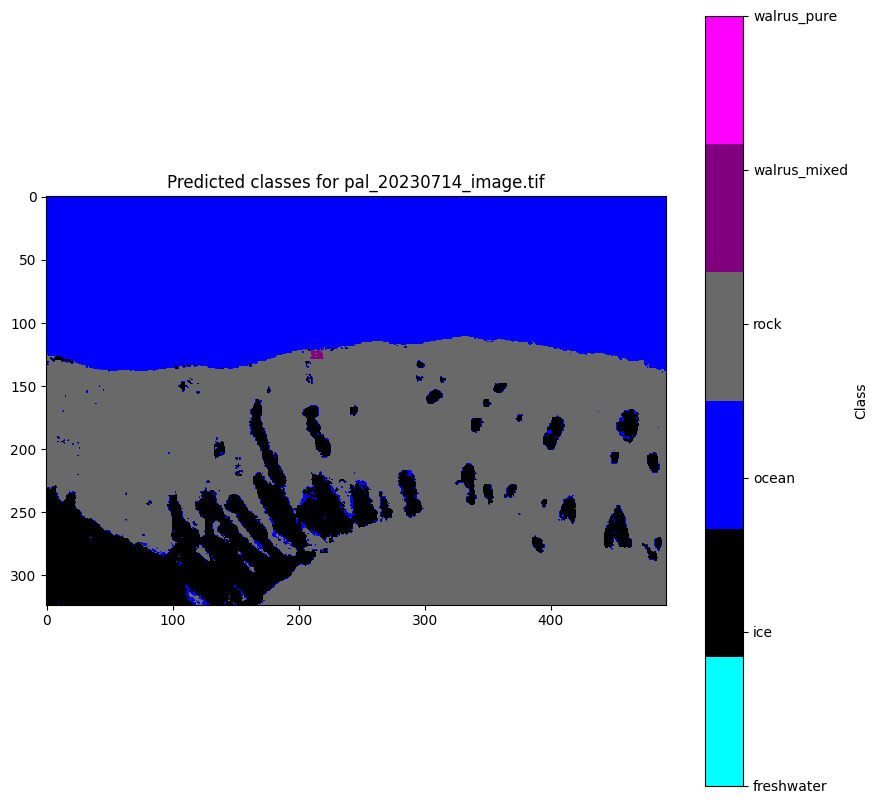

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pal_20230720_image.tif...
Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


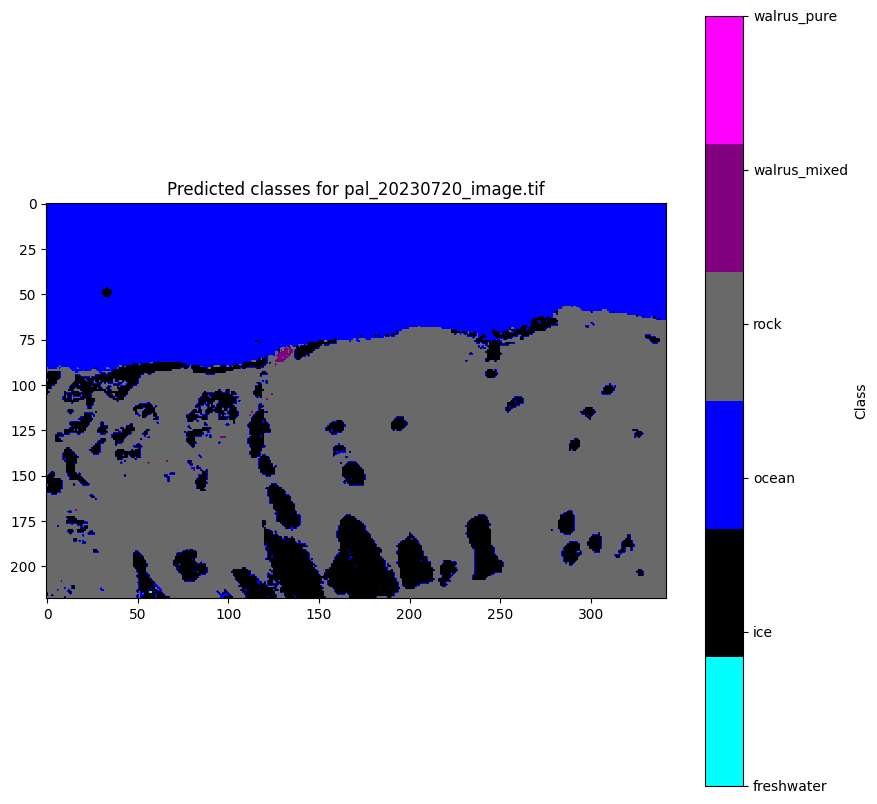

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pal_20230726_image.tif...
Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


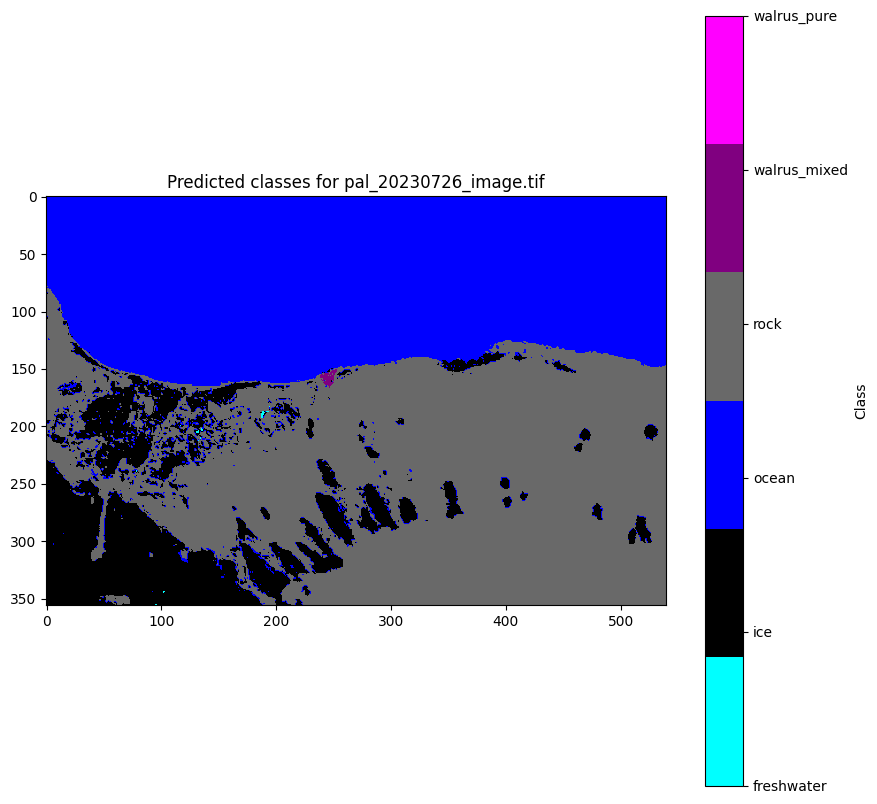

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\sars_20230714_image.tif...
Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


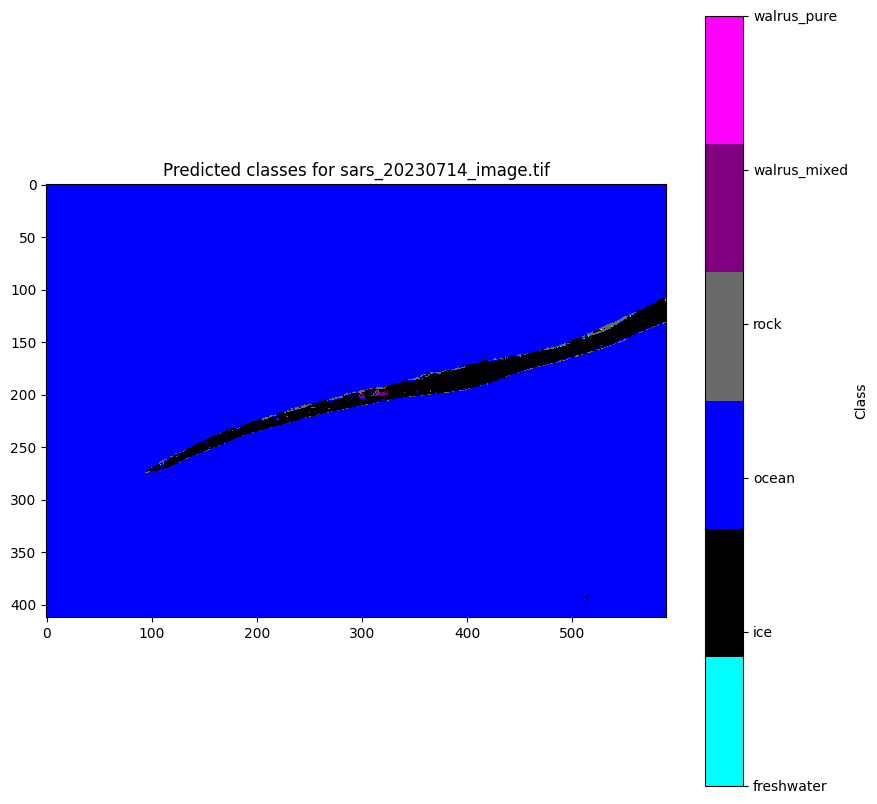

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\sars_20230803_image.tif...
Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


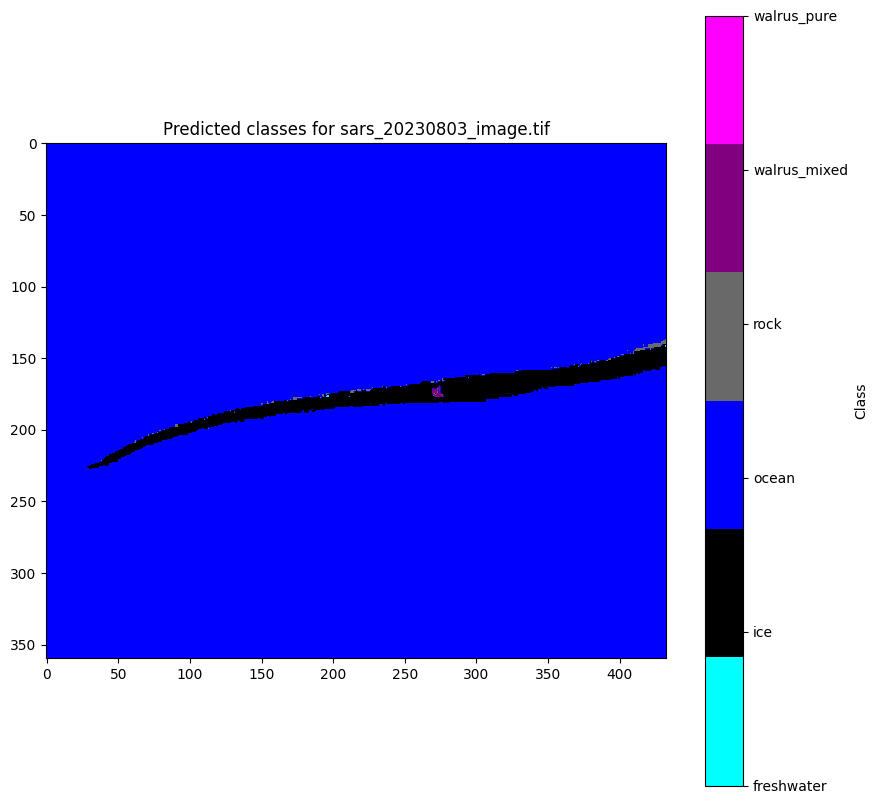

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230801_image.tif...
Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


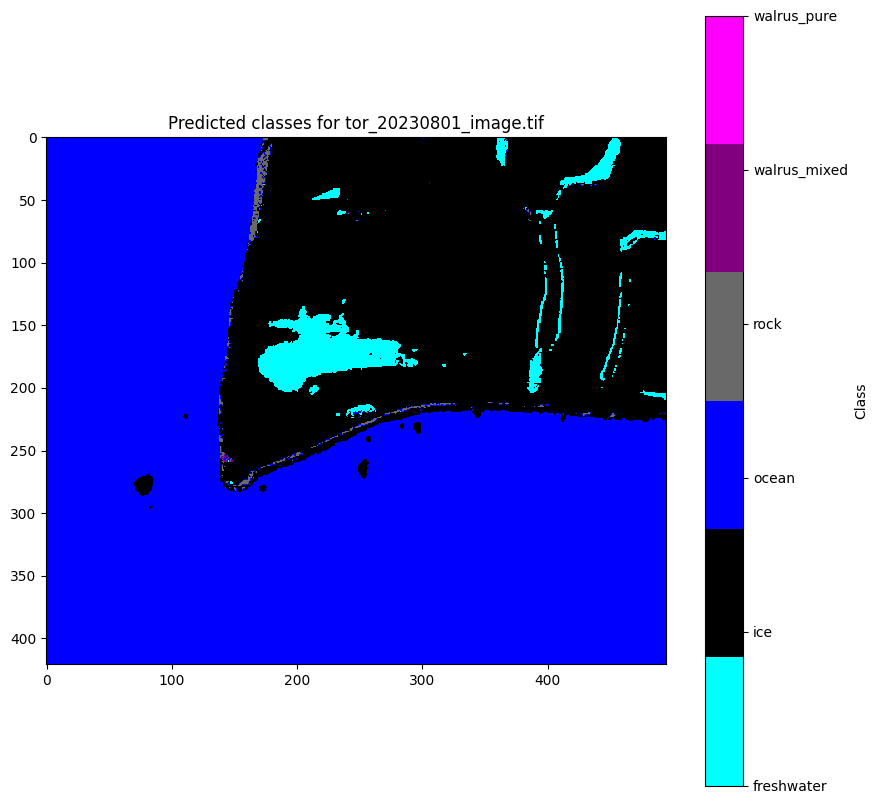

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230824_image.tif...
Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


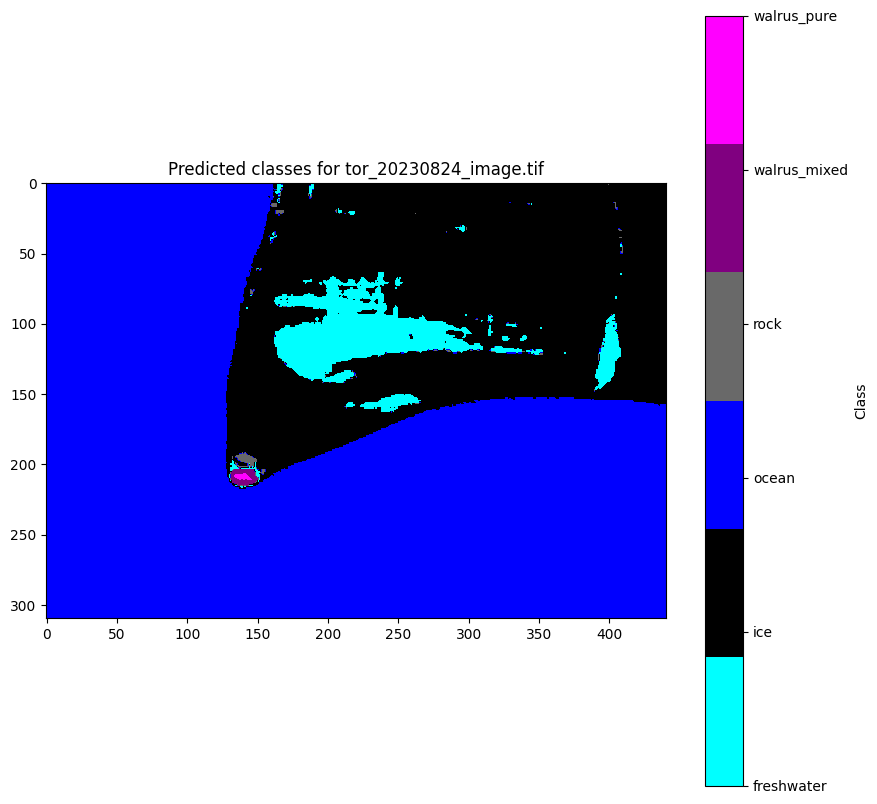

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230901_image.tif...
Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


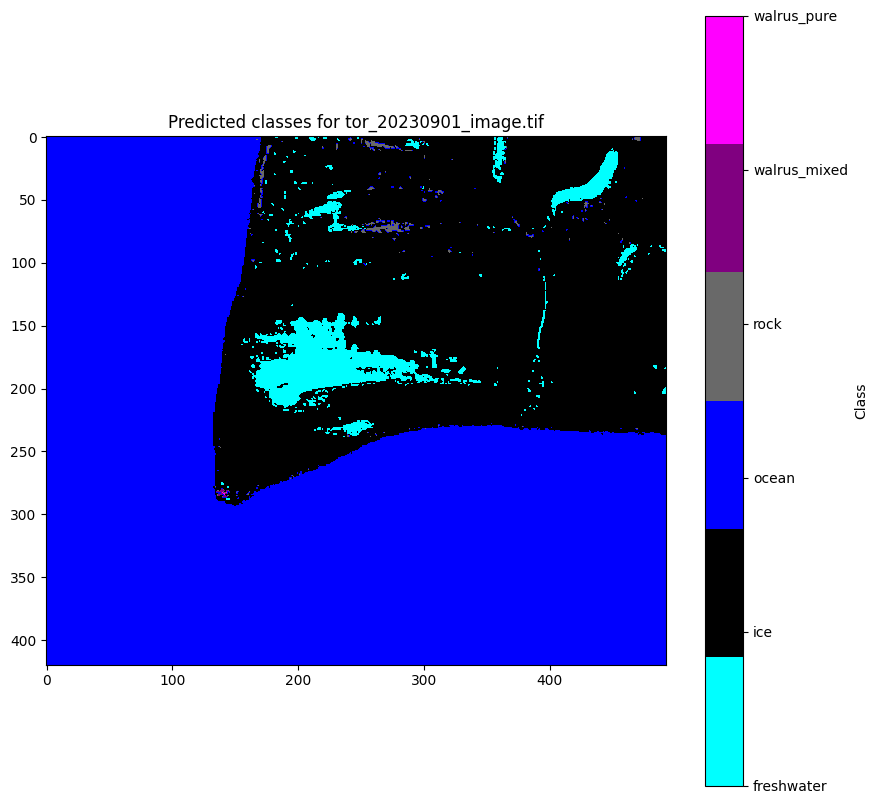

Plotting predicted image for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\tor_20230902_image.tif...
Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


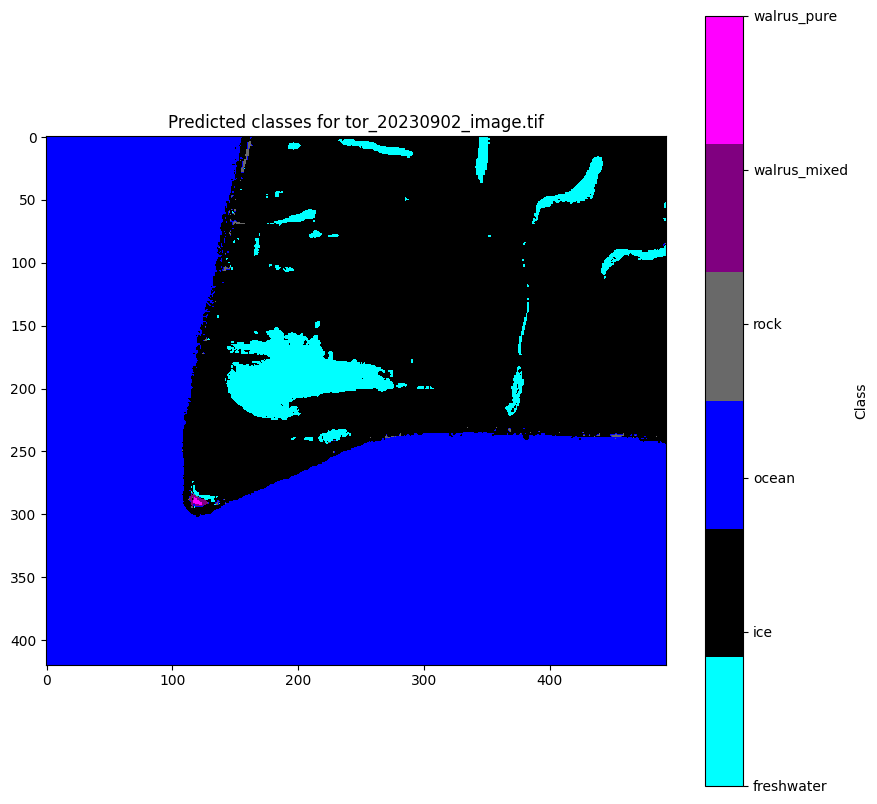

In [18]:
# Define a color map for the labels
label_colors = {'ice': 'black', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'purple', 'freshwater': 'cyan', 'ocean': 'blue'}
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    print(f"Plotting predicted image for {image_path}...")
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()


In [19]:
# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")


Model loaded from walrus_model_allislands3.joblib


In [20]:
for image_path in unlabeled_image_paths:
    print(f"Predicting for unlabeled image {image_path}...")
    predicted_image = predict_image(image_path, loaded_model)
    
    print(f"Plotting predicted image for {image_path}...")
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    plt.show()

# Additional print statements to verify that the image is being predicted and plotted
def predict_image(image_path, model):
    print(f"Predicting classes for {image_path}...")
    with rasterio.open(image_path) as src:
        image = src.read()
        print(f"Image shape: {image.shape}")
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        print(f"Predictions shape: {predictions.shape}")
        return predictions.reshape((src.height, src.width))
